
Processing dam: Ömerli
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0485
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.9191e-04
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.7514e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8152e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.5049e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 1.3981e-04
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 1.3739e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.3988e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.2977e-04
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.1706e-04
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 2.6428e-04
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 2.0195e-04
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 8.9580e-05
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 8.8104e-05
Epoch

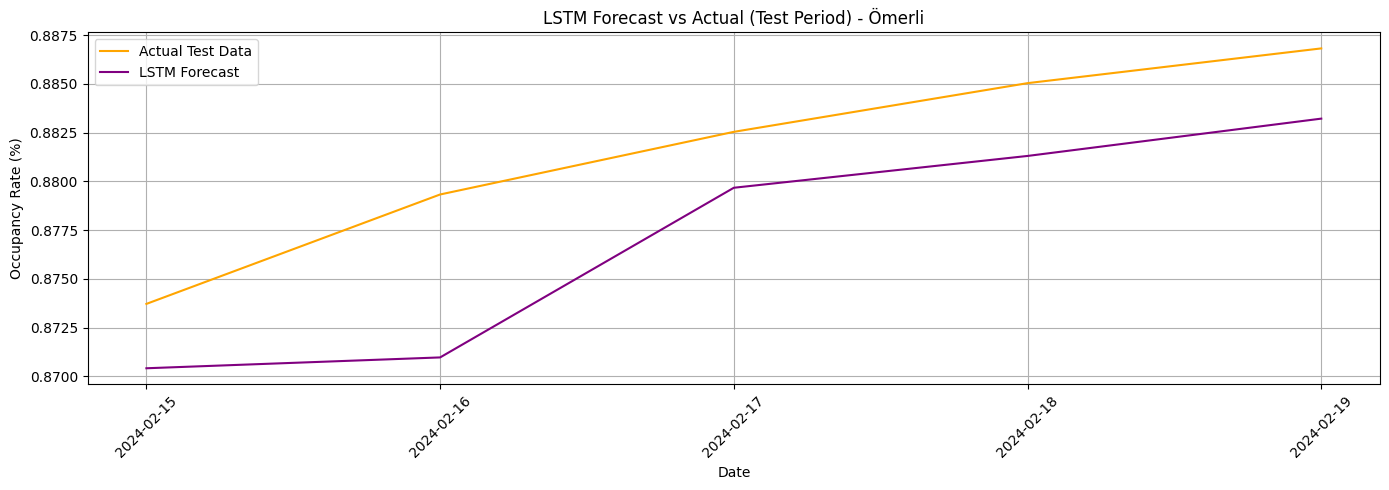


Processing dam: Darlık
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0409
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.9645e-04
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.7717e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.6196e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.4745e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.7809e-04
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.8495e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.0545e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.2894e-04
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.1253e-04
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.8366e-05
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.6277e-04
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.3836e-04
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.2385e-04
Epoch 15/50
529/

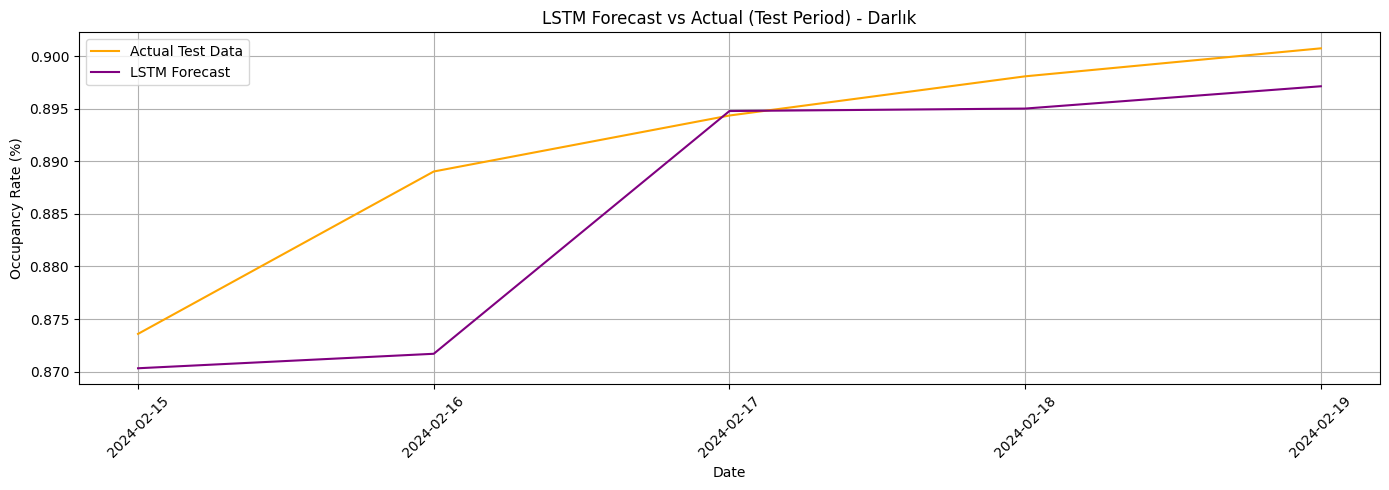


Processing dam: Elmalı
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1154
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0010
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.3137e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.8944e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 4.8193e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 4.0510e-04
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.8073e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.8205e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.6158e-04
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.1442e-04
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.9596e-04
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.1039e-04
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.6580e-04
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.1207e-04
Epoch 15/50
529/529 

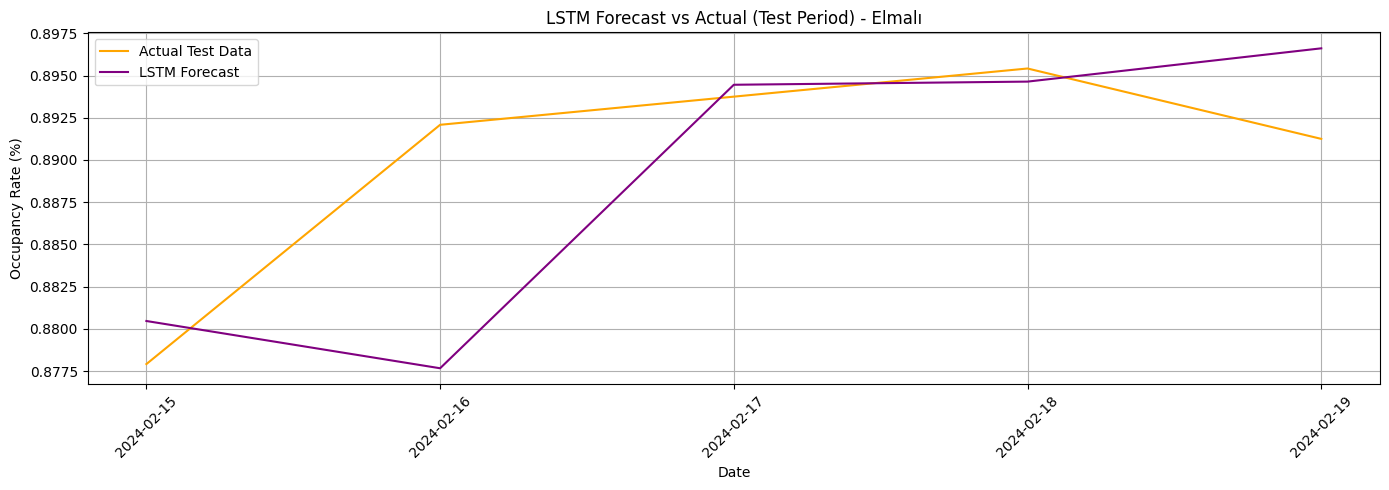


Processing dam: Terkos
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1048
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.8412e-04
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.6263e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.1123e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.7906e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.6244e-04
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.6314e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.3748e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.3793e-04
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.3984e-04
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1448e-04
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1068e-04
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.2571e-04
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.2414e-04
Epoch 15/50
529/

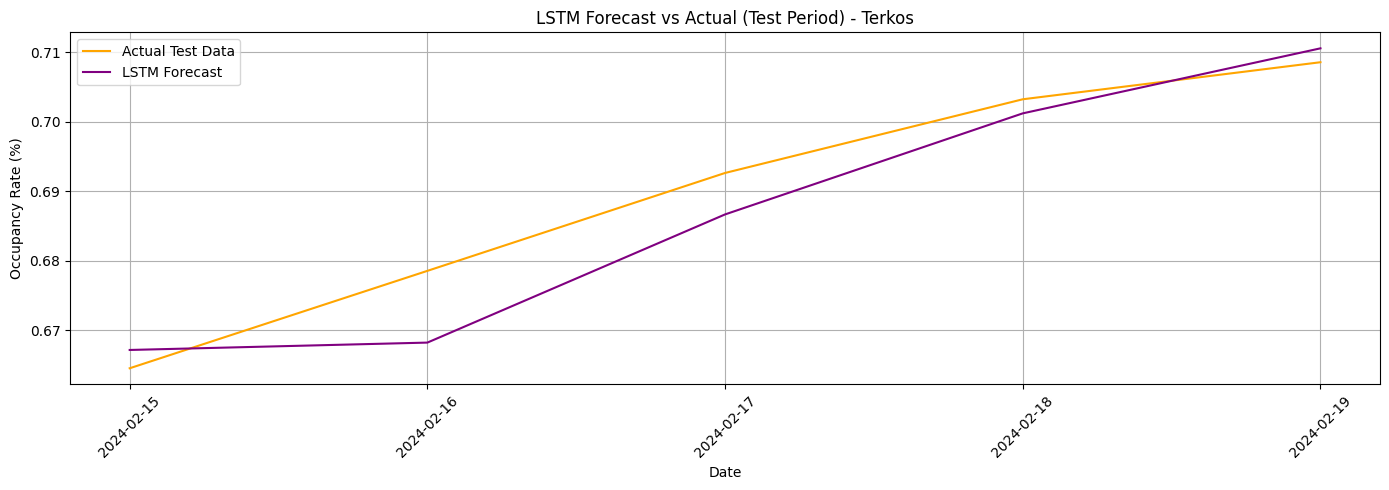


Processing dam: Alibey
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0530
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.9858e-04
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.3258e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.9723e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6896e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8807e-04
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.2062e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.4892e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1358e-04
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.3635e-04
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1594e-04
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0229e-04
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.7683e-05
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.2563e-05
Epoch 15/50
529/

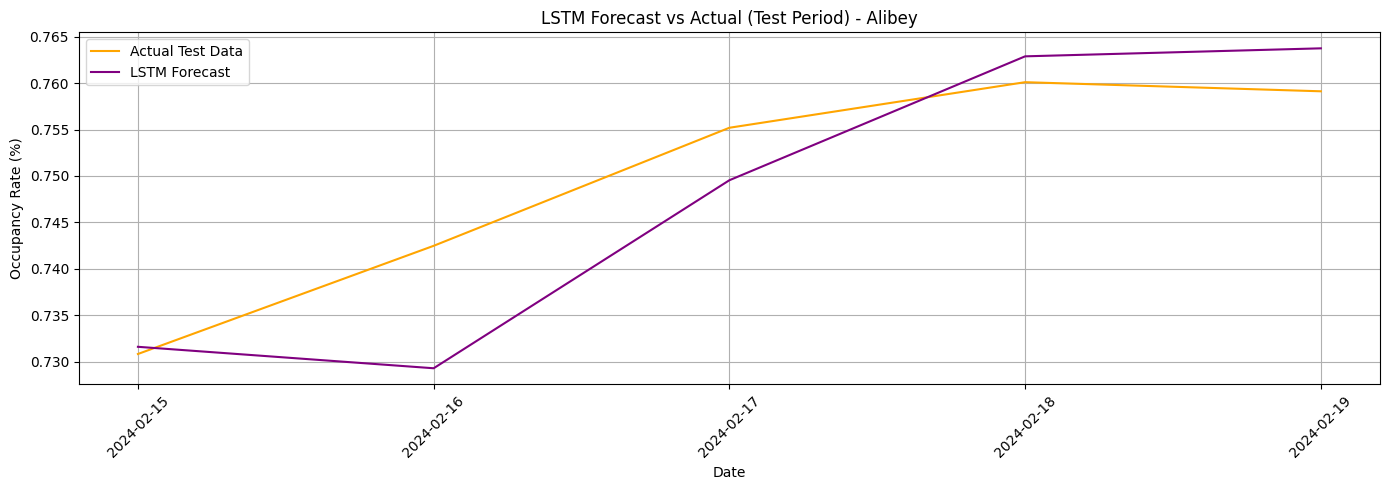


Processing dam: Büyükçekmece
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0441
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.0808e-04
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.8681e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.5906e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.1759e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6888e-04
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.7052e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.5576e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6826e-04
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.3603e-04
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.3586e-04
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0357e-04
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0350e-04
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1841e-04
Epoch 15/50
529/

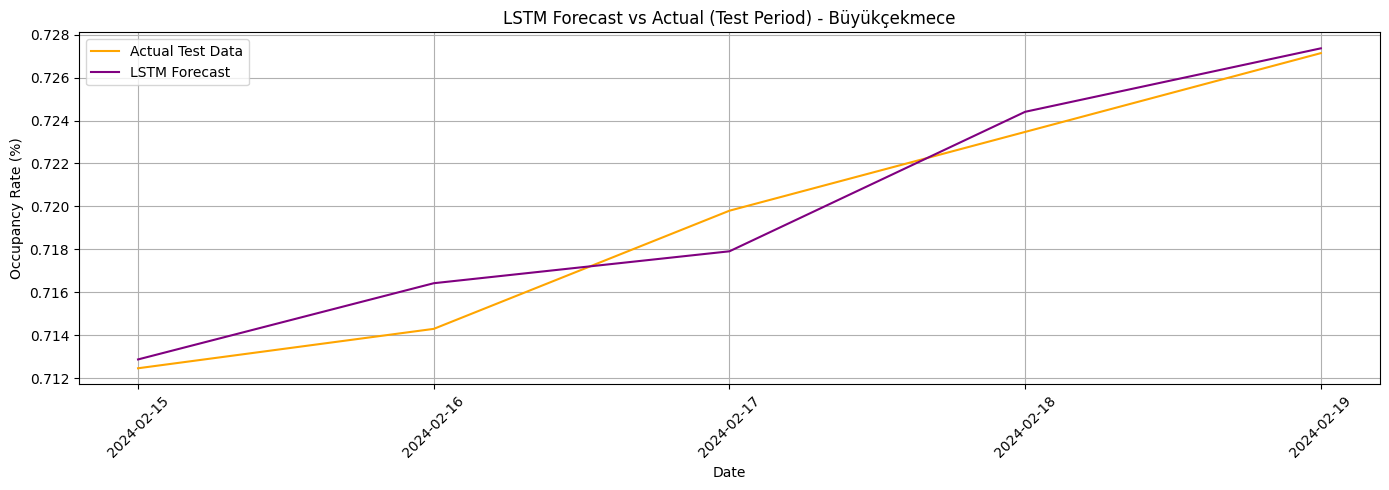


Processing dam: Sazlıdere
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0541
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.9103e-04
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.3121e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.2228e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1890e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1414e-04
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0141e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.0978e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 8.0698e-05
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.0796e-05
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.0986e-04
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.7719e-05
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.4721e-05
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 6.9575e-05
Epoch 15/50
529/

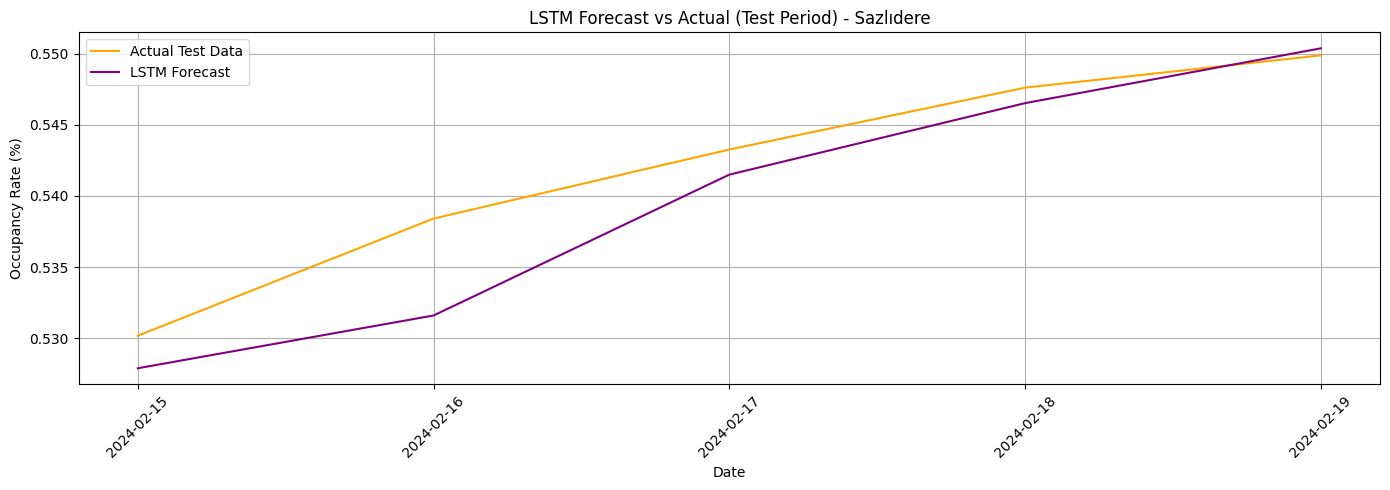


Processing dam: Kazandere
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0871
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 9.0444e-04
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0013
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.5982e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.9773e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.6216e-04
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.5502e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.9494e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.8537e-04
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.7402e-04
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.0186e-04
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.7053e-04
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.1468e-04
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 7.6316e-04
Epoch 15/50
529/529 

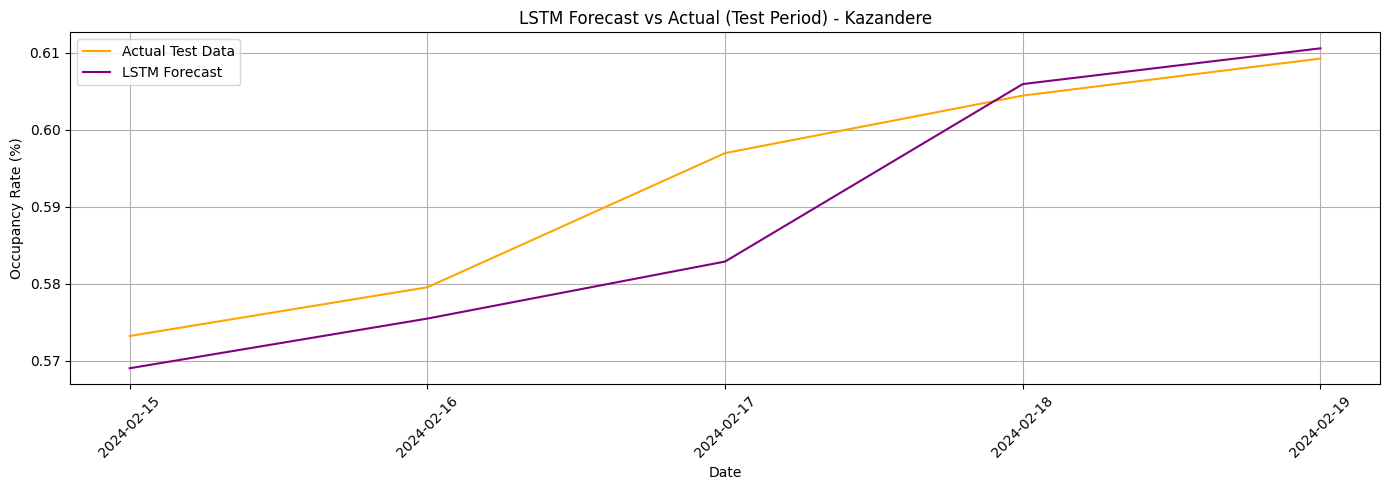


Processing dam: Pabuçdere
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0196
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.1449e-04
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.8973e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.8303e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.6371e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.2607e-04
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.8668e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.7129e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.2236e-04
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.3988e-04
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.0589e-04
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.5463e-04
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.5917e-04
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.9826e-04
Epoch 15/50
529/

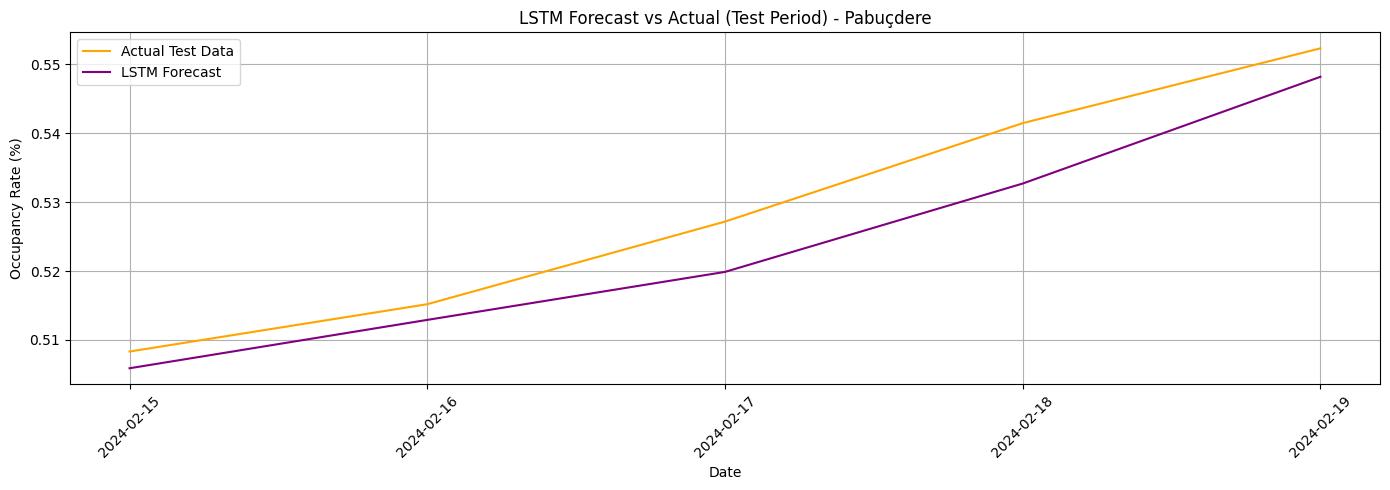


Processing dam: Istrancalar
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0480
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0050
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0031
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0022
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0019
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0015
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0016
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0019
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0018
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0018
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0017
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0016
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0016
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0014
Epoch 15/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0015


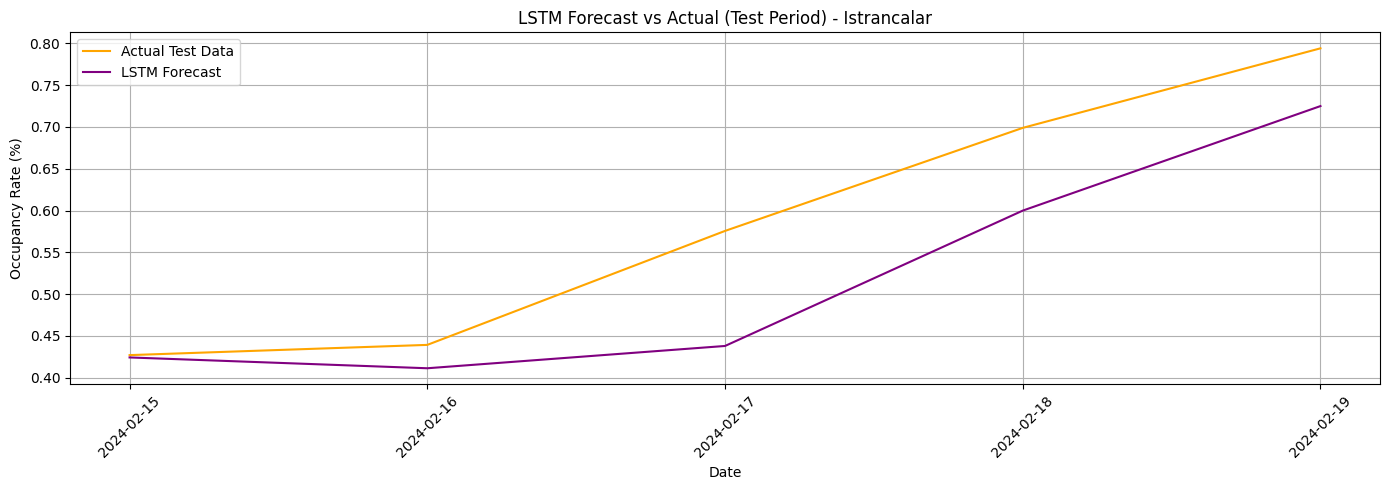

In [3]:
# Importing necessary libraries for data manipulation, modeling, and evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Loading the dam-specific dataset
df = pd.read_excel("../data/raw/istanbul-dams-daily-occupancy-rates.xlsx")

# Converting the 'Tarih' column to datetime using automatic detection with dayfirst
df['Tarih'] = pd.to_datetime(df['Tarih'], dayfirst=True)

# Listing dam columns (excluding 'Tarih')
dams = df.columns[1:]

# Defining look-back period
look_back = 30

# Defining a function to prepare sequences for LSTM
def create_sequences(data, look_back=30):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Iterating over each dam to implement LSTM model and evaluate performance
for dam in dams:
    print(f"\nProcessing dam: {dam}")

    dam_df = df[['Tarih', dam]].dropna()
    dam_df = dam_df.set_index('Tarih')

    # Checking if data is sufficient
    if len(dam_df) <= look_back + 5:
        print(f"Not enough data for {dam}, skipping.")
        continue

    # Splitting data ensuring enough sequence length for both train and test sets
    train = dam_df[:- (look_back + 5)]
    test = dam_df[- (look_back + 5):]

    # Scaling the data using MinMaxScaler
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)

    # Creating sequences for LSTM input
    X_train, y_train = create_sequences(train_scaled, look_back)
    X_test, y_test = create_sequences(test_scaled, look_back)

    # Building the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Training the model
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

    # Making predictions on the test set if data is sufficient
    if len(X_test) > 0:
        predictions = model.predict(X_test)
        predictions_inverse = scaler.inverse_transform(predictions)
        y_test_inverse = scaler.inverse_transform(y_test)

        # Calculating performance metrics
        mae_lstm = mean_absolute_error(y_test_inverse, predictions_inverse)
        rmse_lstm = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))

        print(f"LSTM MAE (Test Set): {mae_lstm:.2f}")
        print(f"LSTM RMSE (Test Set): {rmse_lstm:.2f}")

        # Preparing dates for plotting
        test_dates = test.index[look_back:]

        # Plotting actual vs predicted with clean date formatting
        plt.figure(figsize=(14, 5))
        plt.plot(test_dates, y_test_inverse.flatten(), label='Actual Test Data', color='orange')
        plt.plot(test_dates, predictions_inverse.flatten(), label='LSTM Forecast', color='purple')
        plt.title(f"LSTM Forecast vs Actual (Test Period) - {dam}")
        plt.xlabel("Date")
        plt.ylabel("Occupancy Rate (%)")
        plt.legend()
        plt.grid(True)

        # Setting x-axis date format to show Year-Month-Day only
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Not enough X_test data after sequence creation for {dam}. Skipping evaluation.")
